# Classification of brain tumors
Author: Emma Kuttainen Thyni

Dataset from kaggle: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri?select=Training

Inspiration from kaggle notebooks: https://www.kaggle.com/code/jaykumar1607/brain-tumor-mri-classification-tensorflow-cnn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/archive/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/archive/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 74/74 [00:26<00:00,  2.77it/s]


In [ ]:
# do data augumentation to training data

from albumentations import Compose, MotionBlur, GaussianBlur, MedianBlur, HorizontalFlip, RandomBrightnessContrast

# define transform, first transform applied is the first one in list
transforms = Compose([HorizontalFlip(p = 0.5), RandomBrightnessContrast(p=0.5), MedianBlur(p=0.2)])

transform_motionblur = Compose([HorizontalFlip(p=0.5), MotionBlur(p=0.2)])


def aug_fn(image, img_size, transform):
    data = {"image":image}
    if transform[0] == 'transform_motionblur':
      aug_data = transform_motionblur(**data)
    elif transform[0] == 'transforms':
      aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

def process_data(image, label, img_size, transform):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size, transform], Tout=tf.float32)
    return aug_img, label

In [ ]:
# create dataset
#from functools import partial

ds_alb_mb = [process_data(X_train[i], y_train[i], img_size=150, transform=np.asarray(['transform_motionblur'])) for i in range(len(y_train))]


#ds_alb_transforms = [process_data(X_train[i], y_train[i], img_size=150, transform=np.asarray(['transforms'])) for i in range(len(y_train))]



In [ ]:
def set_shapes(img, label, img_shape=(150,150,3)):
    img.set_shape((150, 150, 3))   #(img_shape)
    #label.set_shape([])
    label = [label]
    return img, label
#ds_alb = ds_alb.map(set_shapes, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)



Code to view augumented images

In [ ]:
def view_image(idx_imgs, ds, original):
  fig, axes = plt.subplots(5, 2, figsize = (15,15))
  images = []
  labels = []
  for i in idx_imgs:
    image, label = ds[i]
    image = image.numpy()
    images.append(image)
    labels.append(label)
    org_img = original[i]
    images.append(org_img)
    labels.append('OG ' + label)

  # Loop through the images and plot them in the subplots
  for i, ax in enumerate(axes.flat):
      ax.imshow(images[i], cmap='gray')  # Use 'cmap' for grayscale images
      ax.set_title(labels[i])
      ax.axis('off')  # Turn off the axis labels

  # Adjust spacing between subplots
  plt.tight_layout()

  plt.show()


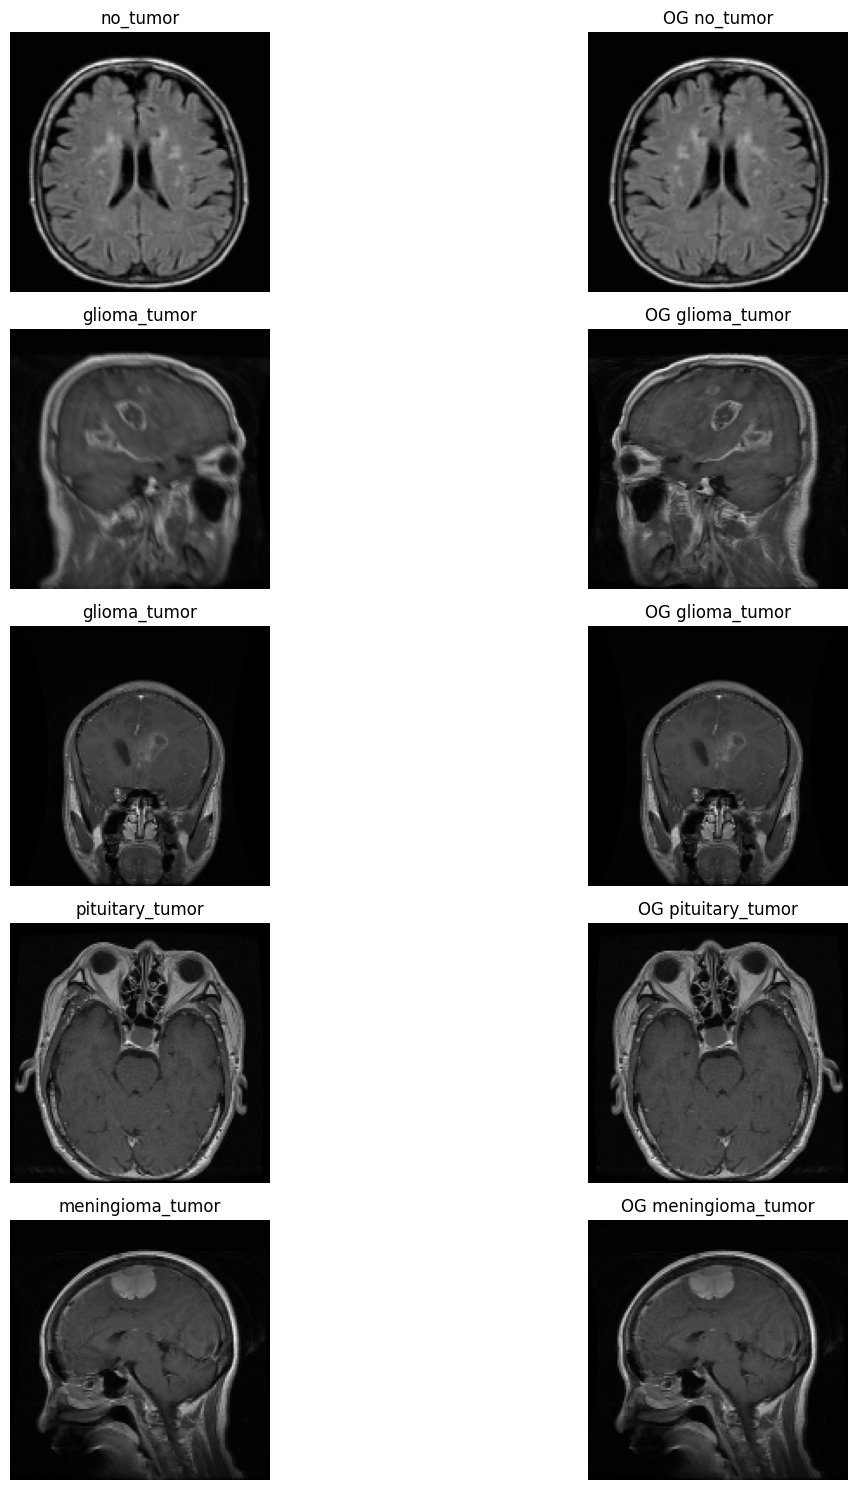

In [ ]:
idx = [1003, 6, 20, 2700, 1555]
view_image(idx, ds_alb_mb, X_train)

In [ ]:
# turn data to numpy format and turn into arrays X_train, y_train
X_train_mb = np.asarray([ds_alb_mb[i][0].numpy() for i in range(len(ds_alb_mb))])
y_train_mb = np.asarray([ds_alb_mb[i][1] for i in range(len(ds_alb_mb))])

#X_train_trans = np.asarray([ds_alb_transforms[i][0].numpy() for i in range(len(ds_alb_transforms))])
#y_train_trans = np.asarray([ds_alb_transforms[i][1] for i in range(len(ds_alb_transforms))])

#print(X_train_mb.shape, y_train_mb.shape)

In [ ]:
# do the same augumentations to the test data
test_mb = [process_data(X_test[i], y_test[i], img_size=150, transform=np.asarray(['transform_motionblur'])) for i in range(len(y_test))]
#test_transforms = [process_data(X_test[i], y_test[i], img_size=150, transform=np.asarray(['transforms'])) for i in range(len(y_test))]

# convert format to numpy arrays
X_test_mb = np.asarray([test_mb[i][0].numpy() for i in range(len(test_mb))])
y_test_mb = np.asarray([test_mb[i][1] for i in range(len(test_mb))])

#X_test_trans = np.asarray([test_transforms[i][0].numpy() for i in range(len(test_transforms))])
#y_test_trans = np.asarray([test_transforms[i][1] for i in range(len(test_transforms))])

In [ ]:
# import resnet network with pretrained weights from Ida
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/DDLS project/resnet.h5')

In [ ]:
# modify network and add 5 more layers to build a classifier

from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

input = model.input
new_output = model.layers[-3].output
pretrained_model = tf.keras.Model(inputs=input, outputs=new_output)

# Freeze the layers in the pretrained model
#for layer in pretrained_model.layers:
#    layer.trainable = False

# Add a new classifier on top of the pretrained model
x = pretrained_model.output

# Add Batch Normalization
x = BatchNormalization()(x)

# Add two Dense layers with decreasing size and ReLU activation
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# Add a Dropout layer for regularization
x = Dropout(0.5)(x)

# Add the final Dense layer with softmax activation for classification
output = Dense(4, activation='softmax')(x)  # 4 classes for this classification task

# Create the combined model
model = tf.keras.Model(inputs=pretrained_model.input, outputs=output)



In [ ]:
model.summary()

###Now train a my network on the training set

In [ ]:
# first shuffle data. Split into validation set
X_train_mb, y_train_mb = shuffle(X_train_mb, y_train_mb, random_state = 101)
X_train_mb, X_val_mb, y_train_mb, y_val_mb = train_test_split(X_train_mb,y_train_mb, test_size=0.1,random_state=101)

#X_train_trans, y_train_trans = shuffle(X_train_trans, y_train_trans, random_state = 101)
#X_train_trans, X_val_trans, y_train_trans, y_val_trans = train_test_split(X_train_trans,y_train_trans, test_size=0.1,random_state=101)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_mb), y=y_train_mb)
class_dict = {0:class_weights[0], 1:class_weights[1], 2:class_weights[2], 3:class_weights[3]}

In [ ]:
# do one hot encoding

# motion blur
y_train_mb_oh = []
for i in y_train_mb:
    y_train_mb_oh.append(labels.index(i))
y_train_mb_oh = tf.keras.utils.to_categorical(y_train_mb_oh)

y_test_mb_oh = []
for i in y_test_mb:
    y_test_mb_oh.append(labels.index(i))
y_test_mb_oh = tf.keras.utils.to_categorical(y_test_mb_oh)

y_val_mb_oh = []
for i in y_val_mb:
    y_val_mb_oh.append(labels.index(i))
y_val_mb_oh = tf.keras.utils.to_categorical(y_val_mb_oh)

# other transformations
 # y_train_trans_new = []
 # for i in y_train_trans:
 #     y_train_trans_new.append(labels.index(i))
 # y_train_trans = y_train_trans_new
 # y_train_trans = tf.keras.utils.to_categorical(y_train_trans)

 # y_test_trans_new = []
 # for i in y_test_trans:
  #    y_test_trans_new.append(labels.index(i))
  #y_test_trans = y_test_trans_new
  #y_test_trans = tf.keras.utils.to_categorical(y_test_trans)

#y_val_new_trans = []
#for i in y_val_trans:
#    y_val_new_trans.append(labels.index(i))
#y_val_trans = y_val_new_trans
#y_val_trans = tf.keras.utils.to_categorical(y_val_trans)

# Now train the network on my training set

In [ ]:
# compile model with loss function and accuracy
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("new_model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train_mb,y_train_mb_oh, validation_data=(X_val_mb, y_val_mb_oh), epochs =20, verbose=1,
                    callbacks=[tensorboard,checkpoint,reduce_lr] , class_weight=class_dict)

Epoch 1/20
81/81 [==============================] - ETA: 0s - loss: 0.2660 - accuracy: 0.9222
Epoch 1: val_accuracy improved from -inf to 0.18118, saving model to new_model.h5
81/81 [==============================] - 18s 219ms/step - loss: 0.2660 - accuracy: 0.9222 - val_loss: 2.5632 - val_accuracy: 0.1812 - lr: 1.0000e-06
Epoch 2/20
81/81 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.9253
Epoch 2: val_accuracy improved from 0.18118 to 0.19164, saving model to new_model.h5
81/81 [==============================] - 18s 226ms/step - loss: 0.2449 - accuracy: 0.9253 - val_loss: 2.0056 - val_accuracy: 0.1916 - lr: 1.0000e-06
Epoch 3/20
81/81 [==============================] - ETA: 0s - loss: 0.2362 - accuracy: 0.9253
Epoch 3: val_accuracy improved from 0.19164 to 0.39721, saving model to new_model.h5
81/81 [==============================] - 19s 229ms/step - loss: 0.2362 - accuracy: 0.9253 - val_loss: 1.4120 - val_accuracy: 0.3972 - lr: 1.0000e-06
Epoch 4/20
81/81 [=

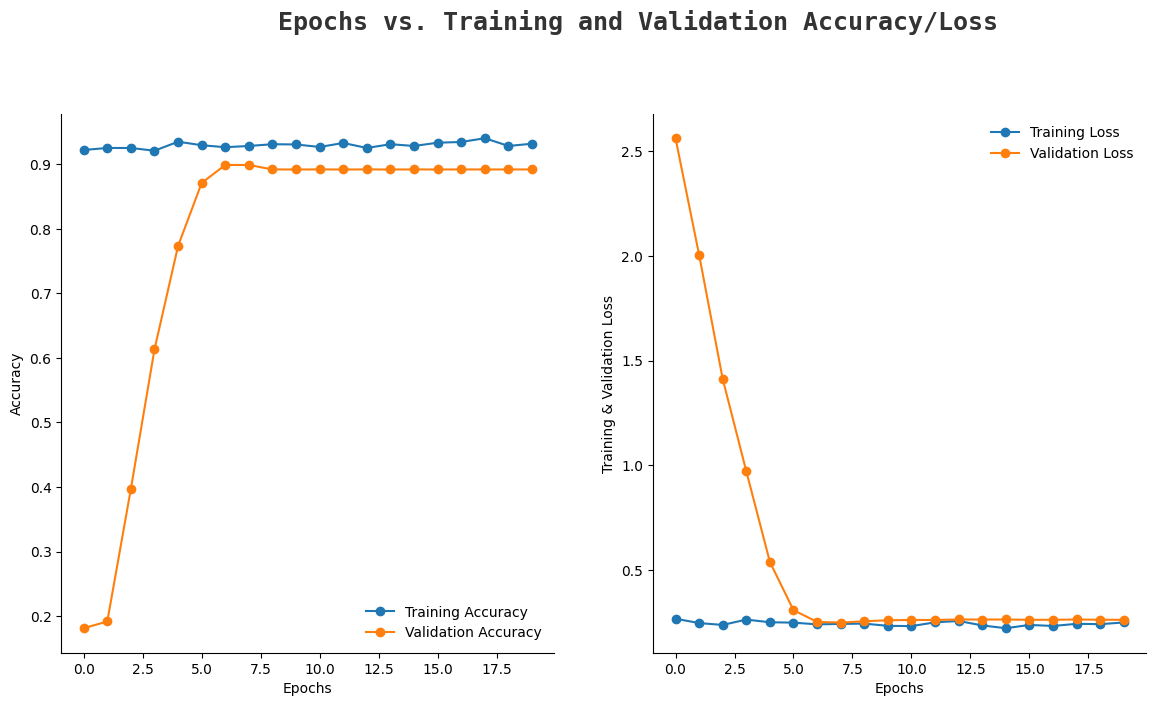

In [ ]:
filterwarnings('ignore')

num_epochs = 12
def PlotRes(history, num_epochs):
  epochs = [i for i in range(num_epochs)]
  fig, ax = plt.subplots(1,2,figsize=(14,7))
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
              fontname='monospace',y=1,x=0.28,alpha=0.8)

  sns.despine()
  ax[0].plot(epochs, train_acc, marker='o',
            label = 'Training Accuracy')
  ax[0].plot(epochs, val_acc, marker='o',
            label = 'Validation Accuracy')
  ax[0].legend(frameon=False)
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')

  sns.despine()
  ax[1].plot(epochs, train_loss, marker='o',
            label ='Training Loss')
  ax[1].plot(epochs, val_loss, marker='o',
            label = 'Validation Loss')
  ax[1].legend(frameon=False)
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Training & Validation Loss')

  fig.show()

PlotRes(history,num_epochs=20)

In [ ]:
# save network weights
import shutil
source_path = 'new_model.h5'
path = 'drive/MyDrive/whole_model_train_hf_mb.h5'

shutil.copy(source_path, path)

'drive/MyDrive/whole_model_train_hf_mb.h5'

# Make prediction on test set

In [ ]:
y_pred = model.predict(X_test_mb)

# y_pred contains floats, choose maximum to represent the class chosen (by index)
y_pred = np.argmax(y_pred, axis = 1)

# need to convert the one hot encoded y_test_mb_oh with this function too to be able to compare
y_test_new = np.argmax(y_test_mb_oh, axis=1)

13/13 [==============================] - 3s 112ms/step


# Plot heatmaps of confusion matrix and classification report
In this,
0 - Glioma Tumor
1 - No Tumor
2 - Meningioma Tumor
3 - Pituitary Tumor

In [ ]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.15      0.25       100
           1       0.52      0.88      0.65       105
           2       0.60      0.82      0.69       115
           3       0.67      0.39      0.50        74

    accuracy                           0.58       394
   macro avg       0.66      0.56      0.52       394
weighted avg       0.65      0.58      0.53       394



In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_new, y_pred))

0.583756345177665


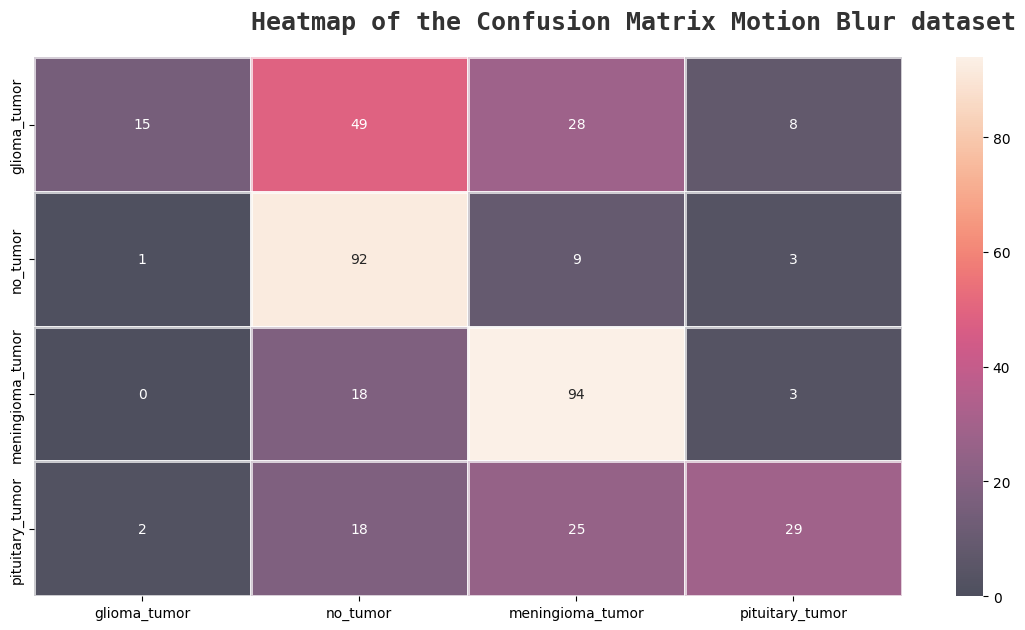

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,y_pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix Motion Blur dataset',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

# Perform test time augumentation
This might improve the accuracy of the classifier

In [ ]:
!pip install edafa

In [ ]:
# use edafa to perform tta
from edafa import ClassPredictor

class myPredictor(ClassPredictor):
    def __init__(self,model,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.model = model

    def predict_patches(self,patches):
        return self.model.predict(patches)

In [ ]:
# define configuration file for tta
conf = '{"augs":["NO", "FLIP_LR", "BRIGHT", "CONTRAST", "GAUSSIAN", "GAMMA"],"mean":"ARITH"}'

In [ ]:
# perform tta for mb test set
predictor_tta = myPredictor(model, conf)
y_pred_tta = predictor_tta.predict_patches(X_test_mb)

13/13 [==============================] - 1s 56ms/step


In [ ]:
# accuracy and classification report with tta
y_pred_tta_new = np.argmax(y_pred_tta, axis=1)

print(classification_report(y_test_new, y_pred_tta_new))

              precision    recall  f1-score   support

           0       0.83      0.15      0.25       100
           1       0.52      0.88      0.65       105
           2       0.60      0.82      0.69       115
           3       0.67      0.39      0.50        74

    accuracy                           0.58       394
   macro avg       0.66      0.56      0.52       394
weighted avg       0.65      0.58      0.53       394



In [ ]:
print(accuracy_score(y_test_new, y_pred_tta_new))

0.583756345177665


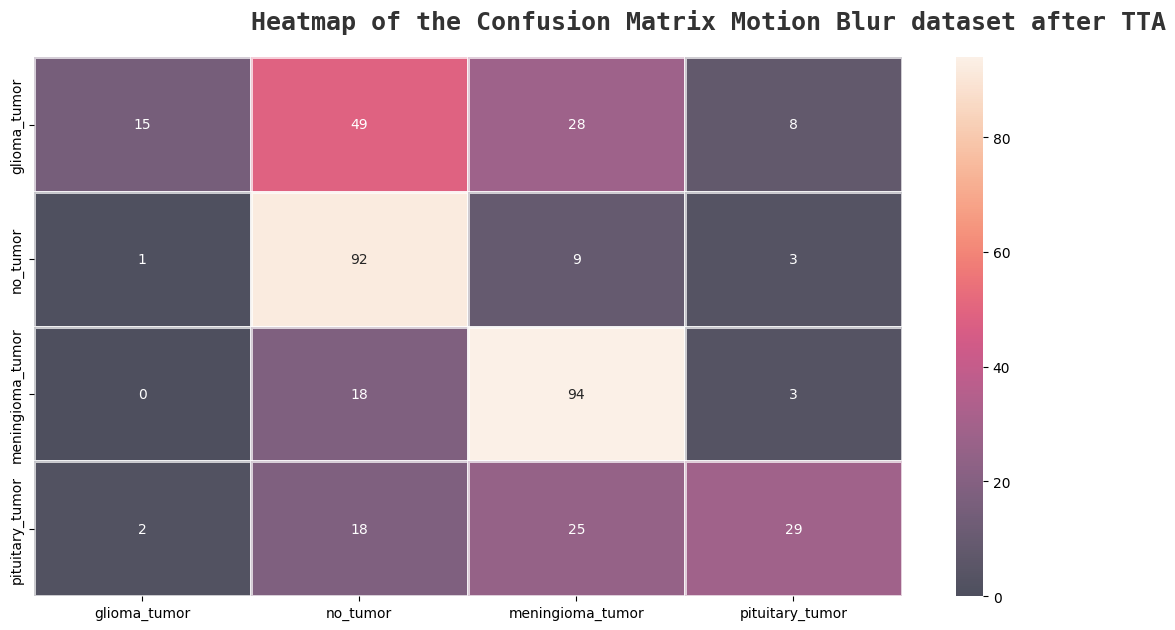

In [ ]:
# get heatmap of confusion matrix
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,y_pred_tta_new),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix Motion Blur dataset after TTA',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

# Test on non augumented data and see if tta improves performance

In [ ]:
# import resnet network with pretrained weights from Ida
model_na = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/DDLS project/resnet.h5')
# modify network and add 5 more layers to build a classifier

from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

input_na = model_na.input
new_output_na = model_na.layers[-3].output
pretrained_model_na = tf.keras.Model(inputs=input_na, outputs=new_output_na)

# Freeze the layers in the pretrained model
#for layer in pretrained_model.layers:
#    layer.trainable = False

# Add a new classifier on top of the pretrained model
xna = pretrained_model_na.output

xna = Dense(256, activation='relu')(xna)

# Add Batch Normalization
xna = BatchNormalization()(xna)

xna = Dense(128, activation='relu')(xna)

# Add a Dropout layer for regularization
xna = Dropout(0.5)(xna)

# Add the final Dense layer with softmax activation for classification
output_na = Dense(4, activation='softmax')(xna)  # 4 classes for this classification task

# Create the combined model
model_na = tf.keras.Model(inputs=pretrained_model_na.input, outputs=output_na)

In [ ]:
# shuffle and split original data into training and validation set
X_train_na, y_train_na = shuffle(X_train, y_train, random_state=101)

X_train_na, X_val_na, y_train_na, y_val_na =  train_test_split(X_train_na, y_train_na)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights_na = compute_class_weight('balanced', classes=np.unique(y_train_na), y=y_train_na)
class_dict_na = {0:class_weights_na[0], 1:class_weights_na[1], 2:class_weights_na[2], 3:class_weights_na[3]}

In [ ]:
# one hot encoding
y_train_na_oh = []
for i in y_train_na:
    y_train_na_oh.append(labels.index(i))
y_train_na_oh = tf.keras.utils.to_categorical(y_train_na_oh)

y_test_na_oh = []
for i in y_test:
    y_test_na_oh.append(labels.index(i))
y_test_na_oh = tf.keras.utils.to_categorical(y_test_na_oh)

y_val_na_oh = []
for i in y_val_na:
    y_val_na_oh.append(labels.index(i))
y_val_na_oh = tf.keras.utils.to_categorical(y_val_na_oh)

In [ ]:
model_na.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("model_na_2.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history_na = model_na.fit(X_train_na,y_train_na_oh, validation_data=(X_val_na, y_val_na_oh), epochs =20, verbose=1,
                    callbacks=[tensorboard,checkpoint,reduce_lr] , class_weight=class_dict_na)

Epoch 1/20
68/68 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.8267
Epoch 1: val_accuracy improved from -inf to 0.31198, saving model to model_na_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/68 [==============================] - 87s 251ms/step - loss: 0.5732 - accuracy: 0.8267 - val_loss: 133.7740 - val_accuracy: 0.3120 - lr: 0.0010
Epoch 2/20
68/68 [==============================] - ETA: 0s - loss: 0.7538 - accuracy: 0.7570
Epoch 2: val_accuracy did not improve from 0.31198
68/68 [==============================] - 11s 162ms/step - loss: 0.7538 - accuracy: 0.7570 - val_loss: 403.8629 - val_accuracy: 0.2827 - lr: 0.0010
Epoch 3/20
68/68 [==============================] - ETA: 0s - loss: 0.6188 - accuracy: 0.8076
Epoch 3: val_accuracy improved from 0.31198 to 0.39972, saving model to model_na_2.h5
68/68 [==============================] - 12s 183ms/step - loss: 0.6188 - accuracy: 0.8076 - val_loss: 1.4855 - val_accuracy: 0.3997 - lr: 0.0010
Epoch 4/20
68/68 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.8425
Epoch 4: val_accuracy improved from 0.39972 to 0.79109, saving model to model_na_2.h5
68/68 [==============================] - 12s 179ms/step 

In [ ]:
def PlotRes(history, num_epochs):
  epochs = [i for i in range(num_epochs)]
  fig, ax = plt.subplots(1,2,figsize=(14,7))
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
              fontname='monospace',y=1,x=0.28,alpha=0.8)

  sns.despine()
  ax[0].plot(epochs, train_acc, marker='o',
            label = 'Training Accuracy')
  ax[0].plot(epochs, val_acc, marker='o',
            label = 'Validation Accuracy')
  ax[0].legend(frameon=False)
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')

  sns.despine()
  ax[1].plot(epochs, train_loss, marker='o',
            label ='Training Loss')
  ax[1].plot(epochs, val_loss, marker='o',
            label = 'Validation Loss')
  ax[1].legend(frameon=False)
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Training & Validation Loss')

  fig.show()

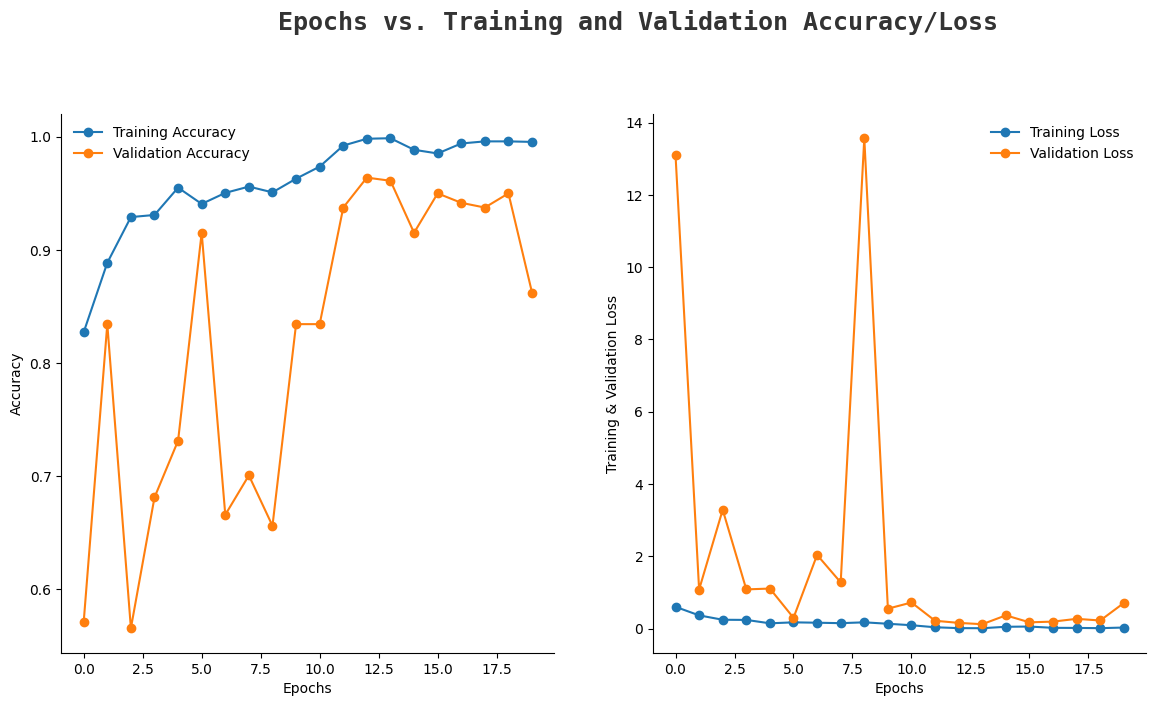

In [ ]:
PlotRes(history_na, 20)

In [ ]:
import shutil
source_path = 'model_na.h5'
path = 'drive/MyDrive/model_na.h5'

shutil.copy(source_path, path)

'drive/MyDrive/model_na.h5'

In [ ]:
y_pred_na = model_na.predict(X_test)

# y_pred contains floats, choose maximum to represent the class chosen (by index)
y_pred_na = np.argmax(y_pred_na, axis = 1)

# need to convert the one hot encoded y_test_mb_oh with this function too to be able to compare
y_test_new_na = np.argmax(y_test_na_oh, axis=1)

13/13 [==============================] - 2s 102ms/step


In [ ]:
print(accuracy_score(y_test_new_na, y_pred_na))
print(classification_report(y_test_new_na, y_pred_na))

0.5253807106598984
              precision    recall  f1-score   support

           0       1.00      0.15      0.26       100
           1       0.71      0.56      0.63       105
           2       0.41      0.99      0.58       115
           3       1.00      0.26      0.41        74

    accuracy                           0.53       394
   macro avg       0.78      0.49      0.47       394
weighted avg       0.75      0.53      0.48       394



In [ ]:
# perform tta for mb test set
conf = '{"args":["FLIP_LR", "GAMMA", "BRIGHT", "CONTRAST", "GAUSSIAN"], "mean":"ARITH"}'
predictor_tta_na = myPredictor(model_na, conf)
y_pred_tta_na = predictor_tta_na.predict_patches(X_test)

 2/13 [===>..........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/edafa/BasePredictor.py:74: SyntaxWarning: No "augs" found in configuration file. No augmentations will be used.
  warnings.warn('No "augs" found in configuration file. No augmentations will be used.',SyntaxWarning)
/usr/local/lib/python3.10/dist-packages/edafa/BasePredictor.py:89: SyntaxWarning: No "bits" found in configuration file. 8-bits will be used.
  warnings.warn('No "bits" found in configuration file. 8-bits will be used.',SyntaxWarning)


13/13 [==============================] - 1s 53ms/step


In [ ]:
# accuracy and classification report with tta
y_pred_tta_na = np.argmax(y_pred_tta_na, axis=1)
print(accuracy_score(y_test_new_na, y_pred_tta_na))
print(classification_report(y_test_new_na, y_pred_tta_na))

0.5253807106598984
              precision    recall  f1-score   support

           0       1.00      0.15      0.26       100
           1       0.71      0.56      0.63       105
           2       0.41      0.99      0.58       115
           3       1.00      0.26      0.41        74

    accuracy                           0.53       394
   macro avg       0.78      0.49      0.47       394
weighted avg       0.75      0.53      0.48       394



In [ ]:
def conf_mat(y_true, y_pred, title):
  fig,ax=plt.subplots(1,1,figsize=(14,7))
  sns.heatmap(confusion_matrix(y_true,y_pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
  fig.text(s=title,size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

  plt.show()

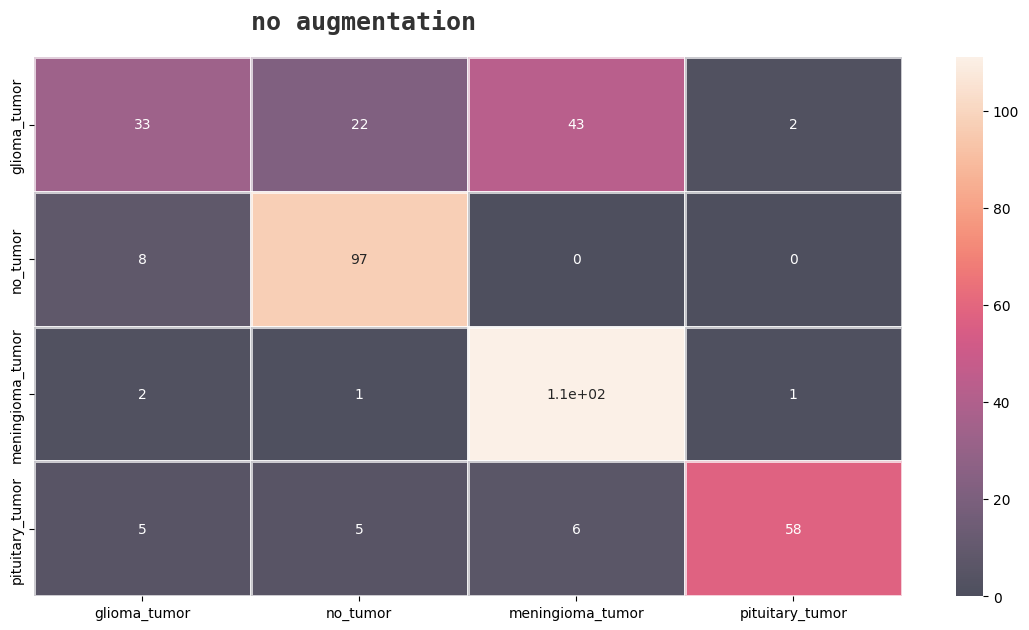

In [ ]:
conf_mat(y_test_new_na, y_pred_na, 'no augmentation')

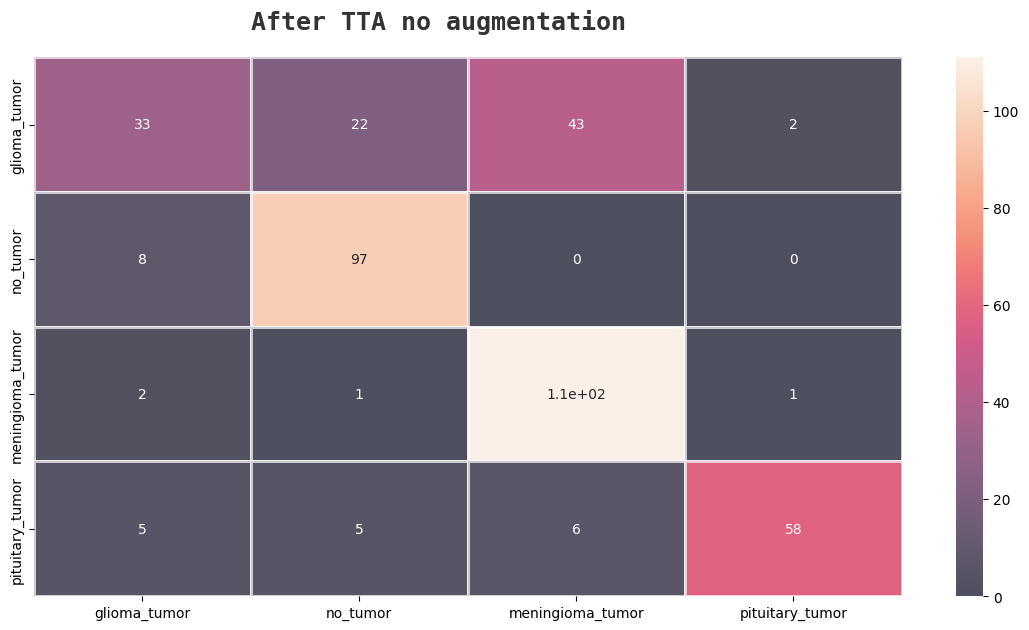

In [ ]:
conf_mat(y_test_new_na, y_pred_tta_na, 'After TTA no augmentation')